In [231]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

In [232]:
#################################
###                           ###
###   Inter-Notebook Loader   ###
###                           ###
#################################
###  This code will load other notebooks in the same directory

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        print("No path")
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % self.path)

        # load the notebook object
        with io.open(self.path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [233]:
feature_transform_path = os.getcwd() + "/feature_transform.ipynb"
nb = NotebookLoader(path=feature_transform_path)

In [234]:
feature_transform = nb.load_module(feature_transform_path)

importing Jupyter notebook from /Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [235]:
df = feature_transform.train_numeric
train = feature_transform.train

In [236]:
neg = df.corr()[df.corr() < -0.5]
neg = neg.dropna(how="all", axis=1)
neg = neg.dropna(how="all", axis=0)
pos = df.corr()[df.corr() > 0.5]
pos = pos[pos < 1.0]
pos = pos.dropna(how="all", axis=1)
pos = pos.dropna(how="all", axis=0)


/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


[None]

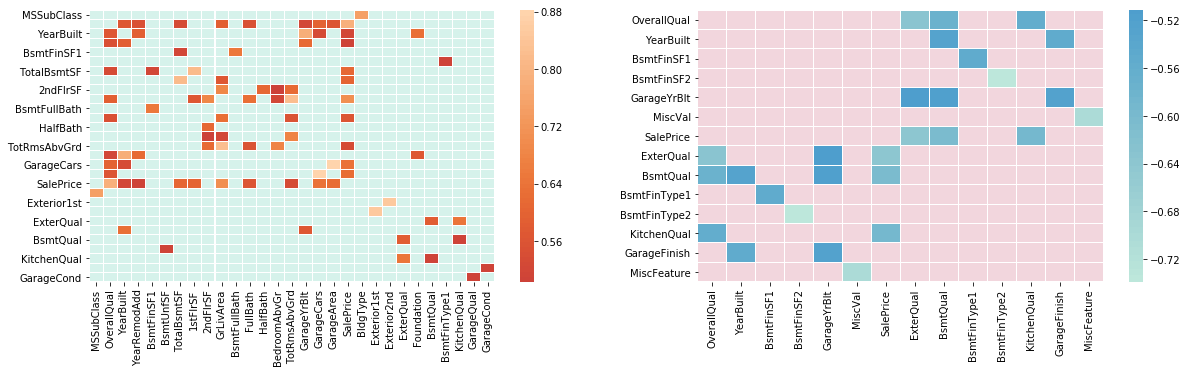

In [237]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
pos_heatmap.set(axis_bgcolor="#D6F2EB")
neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
neg_heatmap.set(axis_bgcolor="#F2D6DD")

### Note:
Is it an issue that when the data is transformed from categorical to numeric, it doesn't retain an order. Common sense suggests "ExterQual" and "KitchenQual" would correlate positively "OverallQual", not negatively.
  
For example:  
"Good" = 4  
"Average" = 5  
"Excellent" = 1  
"Poor" = 2
  
Does this matter?

In [238]:
vals = {}
for i in range(1,len(train)):
    vals[train.iloc[i]["KitchenQual"]] = df.iloc[i]["KitchenQual"]
vals

{'Ex': 2.0, 'Fa': 3.0, 'Gd': 4.0, 'TA': 5.0}